# HDBSCAN should work well on embedding representations

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

## 2a.  Try a really simple averaged word vector model!

With a complex noun extraction function 'cause that part's slow so I multi-threaded it.

In [55]:
from gensim.models import Word2Vec
import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

# Set vector size
vec_size = 100

In [56]:
def get_phrased_nouns(sentences):
    """ Use spacy to get all of the actual entities, conjoin bigram nouns. """

    # Get the lists of nouns
    noun_lists = []
    for doc in sentences:
        parsed = nlp(doc)
        noun_lists.append([token.lemma_ for token in parsed if token.pos_ == 'PROPN'])

    # Build the phrase model
    phrases = Phrases(noun_lists, min_count=5, threshold=0.5)

    # Get the set of phrases present in the model
    results = []
    for nouns in noun_lists:
        results.append(phrases[nouns])

    return results

# Get phrase-conjoined, lemmatized tokens
test = get_phrased_nouns(corpus['clean_text'])

# Detect and conjoin bigrams
model = Word2Vec(test, size=vec_size, window=5, min_count=1, workers=10)

In [57]:
def get_averaged_vec(token_list, model):
    
    vecs = []
    for token in token_list:
        try:
            vector = model.wv[token]
        except: 
            vector = np.zeros(vec_size)
        vecs.append(vector)
    
    if len(vecs) > 0:
        return np.mean(np.asarray(vecs), axis=0)
    else:
        return np.zeros(vec_size)

In [58]:
vectors = [get_averaged_vec(tokens, model) for tokens in test]

## 3. Cluster Text

This is the part where the pipelines get a little more experimental
- First; PCA (HDBSCAN prefers < 50 dimensions if possible) (also, try just fitting 50 vectors!)
- Second; HDBSCAN clustering

In [59]:
embeddings_array = np.vstack(vectors)

# First, PCA the data
pca = PCA(n_components=20, svd_solver='full')

# Fit and check
embeddings_pca = pca.fit_transform(embeddings_array)

# Diagnostic stats - both should show exponential decay
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[9.95546554e-01 1.83023271e-03 1.32128478e-03 5.15654016e-04
 1.40637464e-04 1.02497812e-04 4.48321893e-05 3.18790227e-05
 2.21834075e-05 1.82960419e-05 1.65093099e-05 1.55999975e-05
 1.40713951e-05 1.31120630e-05 1.25442652e-05 1.18554832e-05
 1.09476593e-05 1.00623228e-05 9.41338532e-06 9.32854013e-06]
[160.61727213   6.88675473   5.85139849   3.65544843   1.90902656
   1.62974162   1.0778453    0.90889551   0.7581857    0.68855721
   0.65407254   0.63580468   0.60385134   0.58290392   0.57014336
   0.55426964   0.53262567   0.510635     0.49389471   0.49166388]


In [60]:
# Clusterer fitting
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(embeddings_pca)

# Examine results
Counter(clusterer.labels_)

Counter({-1: 23375,
         199: 888,
         207: 2901,
         173: 14,
         49: 24,
         5: 103,
         24: 36,
         11: 36,
         63: 21,
         14: 33,
         204: 31,
         67: 5,
         4: 42,
         115: 23,
         30: 13,
         54: 30,
         72: 9,
         86: 28,
         0: 65,
         87: 86,
         125: 5,
         99: 7,
         23: 17,
         36: 8,
         12: 48,
         111: 22,
         156: 12,
         82: 18,
         135: 49,
         33: 17,
         177: 5,
         102: 16,
         136: 29,
         45: 5,
         37: 13,
         80: 11,
         62: 6,
         8: 21,
         64: 19,
         155: 12,
         18: 44,
         109: 26,
         134: 22,
         19: 17,
         92: 6,
         104: 23,
         123: 54,
         2: 6,
         166: 27,
         137: 22,
         57: 15,
         35: 34,
         6: 11,
         56: 21,
         168: 6,
         101: 11,
         126: 5,
         185: 5,
   

In [61]:
# Diagnostic - calculate percentage of records assigned "outlier"
100.0 * sum(clusterer.labels_ == -1) / clusterer.labels_.shape[0]

74.45927436052624

In [62]:
len(pd.unique(clusterer.labels_))

209

In [63]:
# Record cluster each was assigned to
corpus['cluster'] = clusterer.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0 - clusterer.outlier_scores_

corpus.to_csv("working/RSS_clustered_w2v_pca.csv", index=False)

C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [71]:
# For calculating silhouette score, a gauge of how well separated clusters
# are in some spatial representation
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings_array, clusterer.labels_, metric="cosine")
score

-0.7346563109058696

c_v: 0.536
c_npmi: 0.0495
Average document word count: 39.30287006657535
Number of documents: 31393
Latest record: Wed, 9 Oct 2019 21:52:38 +0000
Earliest record: Fri, 01 May 2020 00:18:25 GMT
Number of clusters: 209
Median cluster size: 14.0
Clustered docs: 25.5%

Best Performant (C_v)!
2395    US bomb sniffing dogs sent to Jordan dying fro...
3570    Trump impeachment inquiry: Pompeo subpoenaed b...
4682    Samuel Little: Most prolific serial killer in ...
5799    Chinese diplomats must notify their moves in U...
Name: clean_text, dtype: object
16321    Dad who wrongly thought he had coronavirus han...
19945    apos;We need to do everything nowapos;: Los An...
21422    Coronavirus deaths in Spain rise by 88 to 6,52...
22013    Coronavirus: San Francisco to house thousands ...
Name: clean_text, dtype: object
740     British-Iranian academic arrested in Iran amid...
1237    Iran begins injecting uranium into advanced ce...
6250    Russian hackers cloak attacks using Iranian gr...
9016 

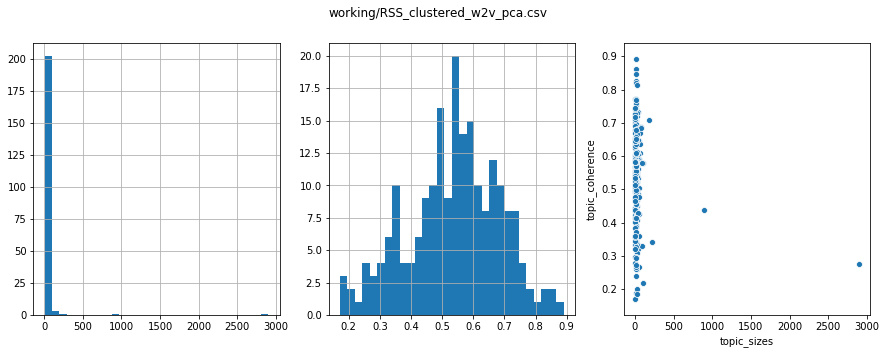

In [69]:
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_w2v_pca.csv")

## 4. Cluster text with Spectral Clustering
Not working on high-dimensional data

In [114]:
from sklearn.metrics.pairwise import cosine_similarity

In [115]:
# Create an adjacency matrix from cosine distances between document vectors
embeddings_array = np.vstack(vectors)
adjacencies = cosine_similarity(embeddings_array)

In [116]:
# Create and fit the clustering model
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=66)
labels = clustering.fit_predict(adjacencies)
pd.Series(labels).value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [118]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(embeddings_array)
labels = ap.labels_
pd.Series(labels).value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:244: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


-1    31393
dtype: int64

In [119]:
from nltk.cluster.kmeans import KMeansClusterer

kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
clusters = kmc.cluster(embeddings_array, True, trace=True)
clusters

k-means trial 0


ValueError: Expected 2D array, got 1D array instead:
array=[-0.09678844 -0.04914731 -0.0918996   0.03148106  0.00692426  0.02474998
 -0.0310649  -0.02250112  0.05037763  0.05495568 -0.04182899  0.10333367
 -0.05581373  0.01879965 -0.07700264 -0.03032341 -0.03557343  0.06771304
  0.02605025  0.06973264 -0.02110648 -0.02923694 -0.05119487 -0.01076027
  0.00174566  0.0030407   0.02972826  0.02488391 -0.01659029  0.03182782
  0.02854276  0.01147087 -0.07295819  0.03566049 -0.0223949   0.04332376
  0.1364155   0.037664   -0.01921118 -0.00619069 -0.00109907 -0.03387676
 -0.04258525 -0.04437709 -0.02700844  0.02641395  0.0064106  -0.05381642
  0.02613112  0.00205968 -0.00765213 -0.00555755 -0.0157114  -0.03708303
 -0.02643336 -0.01312637  0.03380334  0.00098299 -0.00653874 -0.03195605
  0.0195149   0.11072549 -0.00439097  0.05608417  0.03619593  0.04922133
 -0.01214806  0.0562921  -0.01620516 -0.10049026 -0.00202969  0.03484849
 -0.10684189 -0.05593963 -0.00847917  0.02041832 -0.0543266  -0.02564202
  0.0250819   0.02892848 -0.02078645  0.00502697 -0.06083879  0.03798278
 -0.03051088 -0.01015564 -0.02967493 -0.02264585 -0.00457275 -0.09688368
 -0.01052988  0.01150251  0.08832052  0.02863958 -0.00195166  0.0557788
 -0.04898931 -0.00822333  0.00799559 -0.0014846 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.